# Calculating the shortes distance to Geospatial datapoints and making the final datafile

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial.distance import cdist
from geopy.distance import geodesic

# Import data
df_rent = pd.read_csv('3_Final_Rental_data.csv')
df_geo = pd.read_csv('2_Final_Geospatial_data.csv')


In [2]:
# Calculate the distance from each apartment to the nearest object of each type:

# Create a list of unique types from df_geo
unique_types = df_geo['Type'].unique()

# Initialize dictionaries to store distances and coordinates for each type
distances_dict = {}
coordinates_dict = {}

# Loop through each unique type and calculate distances
for obj_type in unique_types:
    # Filter df_geo to get only the specific type
    df_type = df_geo[df_geo['Type'] == obj_type]
    
    # Create a matrix of distances between apartments and objects of the specific type
    distances = cdist(df_rent[['Latitude', 'Longitude']], df_type[['Latitude', 'Longitude']])
    
    # Find the minimum distance for each apartment
    min_distances = np.min(distances, axis=1)
    
    # Find the index of the closest object for each apartment
    min_indices = np.argmin(distances, axis=1)
    
    # Get the corresponding coordinates for the closest object
    closest_coordinates = [(df_type.iloc[idx]['Latitude'], df_type.iloc[idx]['Longitude']) for idx in min_indices]
    
    # Store the closest coordinates in the coordinates dictionary with descriptive column names
    coordinates_dict[f"closest_{obj_type}_latitude"] = [coord[0] for coord in closest_coordinates]
    coordinates_dict[f"closest_{obj_type}_longitude"] = [coord[1] for coord in closest_coordinates]

# Create a new dataframe to store the coordinates
df_coordinates = pd.DataFrame(coordinates_dict)

# Calculate the distances using geodesic and store in distances_dict for all object types
for obj_type in unique_types:
    df_coordinates[f"distance_to_{obj_type}"] = [
        geodesic((apt_lat, apt_lon), (obj_lat, obj_lon)).kilometers
        for apt_lat, apt_lon, obj_lat, obj_lon
        in zip(df_rent['Latitude'], df_rent['Longitude'],
               df_coordinates[f"closest_{obj_type}_latitude"],
               df_coordinates[f"closest_{obj_type}_longitude"])
    ]

# Concatenate df_rent, df_coordinates, and df_distances
df_result = pd.concat([df_rent, df_coordinates], axis=1)

# Save df_result to csv
df_result.to_csv("4_Map_Data.csv", index=False)

df_result


,City,Postal code,Latitude,Longitude,Monthly rent,Aconto,Square meters,Rooms,Furnished,Shareable,...,closest_Hospitals_latitude,closest_Hospitals_longitude,closest_Malls_latitude,closest_Malls_longitude,distance_to_Public Transport Stations,distance_to_Beaches,distance_to_Schools,distance_to_Restaurants,distance_to_Hospitals,distance_to_Malls
0,Odense,5000,55.393856,10.394185,5400.0,800.0,62.0,2.0,0.0,0.0,...,55.384673,10.369726,55.401697,10.387420,0.227327,10.937984,0.347042,0.114848,1.856833,0.972492
1,Rønde,8410,56.300211,10.477949,7100.0,700.0,100.0,4.0,0.0,0.0,...,56.192842,10.171852,56.188926,10.215712,6.490199,5.187801,0.198759,0.081711,22.428327,20.441833
2,Aalborg,9400,57.057390,9.936155,5800.0,300.0,64.0,2.0,0.0,0.0,...,57.048611,9.912702,57.047459,9.926476,2.057982,46.063274,0.894998,1.091345,1.726659,1.252278
3,København,2100,55.721333,12.556324,8200.0,500.0,43.0,1.0,0.0,0.0,...,55.715615,12.565832,55.725838,12.579363,0.684702,2.087369,0.121870,0.253656,0.873095,1.532133
4,Aarhus,8240,56.199538,10.198303,8195.0,600.0,60.0,3.0,0.0,1.0,...,56.192842,10.171852,56.193923,10.194089,1.569096,12.856874,0.929082,0.441412,1.803299,0.677731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,Aalborg,9000,57.053293,9.911053,7600.0,850.0,73.0,2.0,0.0,0.0,...,57.048611,9.912702,57.059808,9.917792,0.158809,45.438610,0.556684,0.239033,0.530896,0.832760
9963,Kolding,6000,55.485419,9.500225,8250.0,1000.0,84.0,3.0,0.0,0.0,...,55.500101,9.486631,55.522019,9.479334,1.342171,1.674266,1.353033,0.310371,1.846679,4.283248
9964,Viborg,8800,56.449611,9.404525,9500.0,1550.0,130.0,4.0,0.0,0.0,...,56.445496,9.404269,56.448744,9.404993,0.466744,33.988380,0.126922,0.030089,0.458502,0.100810
9965,Fuglebjerg,4250,55.307771,11.543354,7150.0,500.0,87.0,3.0,0.0,0.0,...,55.402390,11.366153,55.406328,11.354635,12.496495,10.451021,2.480094,8.383154,15.404188,16.237640


In [3]:
# Clean up the table:
# Drop the columns with coordinates for the objects
columns_to_drop = [col for col in df_result.columns if "_latitude" in col or "_longitude" in col]
df_result_cleaned = df_result.drop(columns=columns_to_drop)

# Drop the "City" column
df_result_cleaned = df_result_cleaned.drop(columns=["City"])
# Drop the "Postal code" column
df_result_cleaned = df_result_cleaned.drop(columns=["Postal code"])

# Rename the distance columns
column_rename_mapping = {
    "distance_to_Public Transport Stations": "Distance to Transport Station (km)",
    "distance_to_Beaches": "Distance to Beach (km)",
    "distance_to_Schools": "Distance to School (km)",
    "distance_to_Restaurants": "Distance to Restaurant (km)",
    "distance_to_Hospitals": "Distance to Hospital (km)",
    "distance_to_Malls": "Distance to Mall (km)",
}

df_result_cleaned = df_result_cleaned.rename(columns=column_rename_mapping)

# Save the cleaned table
df_result_cleaned.to_csv("4_Final_Data.csv", index=False)

df_result_cleaned.head(50)

,Latitude,Longitude,Monthly rent,Aconto,Square meters,Rooms,Furnished,Shareable,Pets allowed,Elevator,...,Floor_-1 to 0,Floor_1-3,Floor_3-8,Floor_9 or above,Distance to Transport Station (km),Distance to Beach (km),Distance to School (km),Distance to Restaurant (km),Distance to Hospital (km),Distance to Mall (km)
0,55.393856,10.394185,5400.0,800.0,62.0,2.0,0.0,0.0,0.0,1.0,...,0,1,0,0,0.227327,10.937984,0.347042,0.114848,1.856833,0.972492
1,56.300211,10.477949,7100.0,700.0,100.0,4.0,0.0,0.0,1.0,0.0,...,0,1,0,0,6.490199,5.187801,0.198759,0.081711,22.428327,20.441833
2,57.057390,9.936155,5800.0,300.0,64.0,2.0,0.0,0.0,0.0,0.0,...,0,1,0,0,2.057982,46.063274,0.894998,1.091345,1.726659,1.252278
3,55.721333,12.556324,8200.0,500.0,43.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0.684702,2.087369,0.121870,0.253656,0.873095,1.532133
4,56.199538,10.198303,8195.0,600.0,60.0,3.0,0.0,1.0,1.0,1.0,...,0,1,0,0,1.569096,12.856874,0.929082,0.441412,1.803299,0.677731
5,56.465990,10.034878,6300.0,650.0,109.0,3.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0.875646,22.387664,0.123045,0.205792,0.278120,1.696457
6,55.973541,10.145876,7600.0,500.0,82.0,3.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0.352284,10.775682,0.403679,0.124096,16.340729,13.096304
7,55.465056,8.456541,8500.0,700.0,72.0,2.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0.327681,0.887079,0.504533,0.089359,0.224610,0.138749
8,56.204861,9.015997,5995.0,0.0,94.0,3.0,0.0,0.0,0.0,1.0,...,0,1,0,0,8.899503,8.677817,0.285981,7.652507,8.303840,7.682953
9,55.243910,9.299112,5250.0,1250.0,85.0,3.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0.628434,19.025887,0.219876,0.215711,9.248625,31.633539


# Inspection of Data

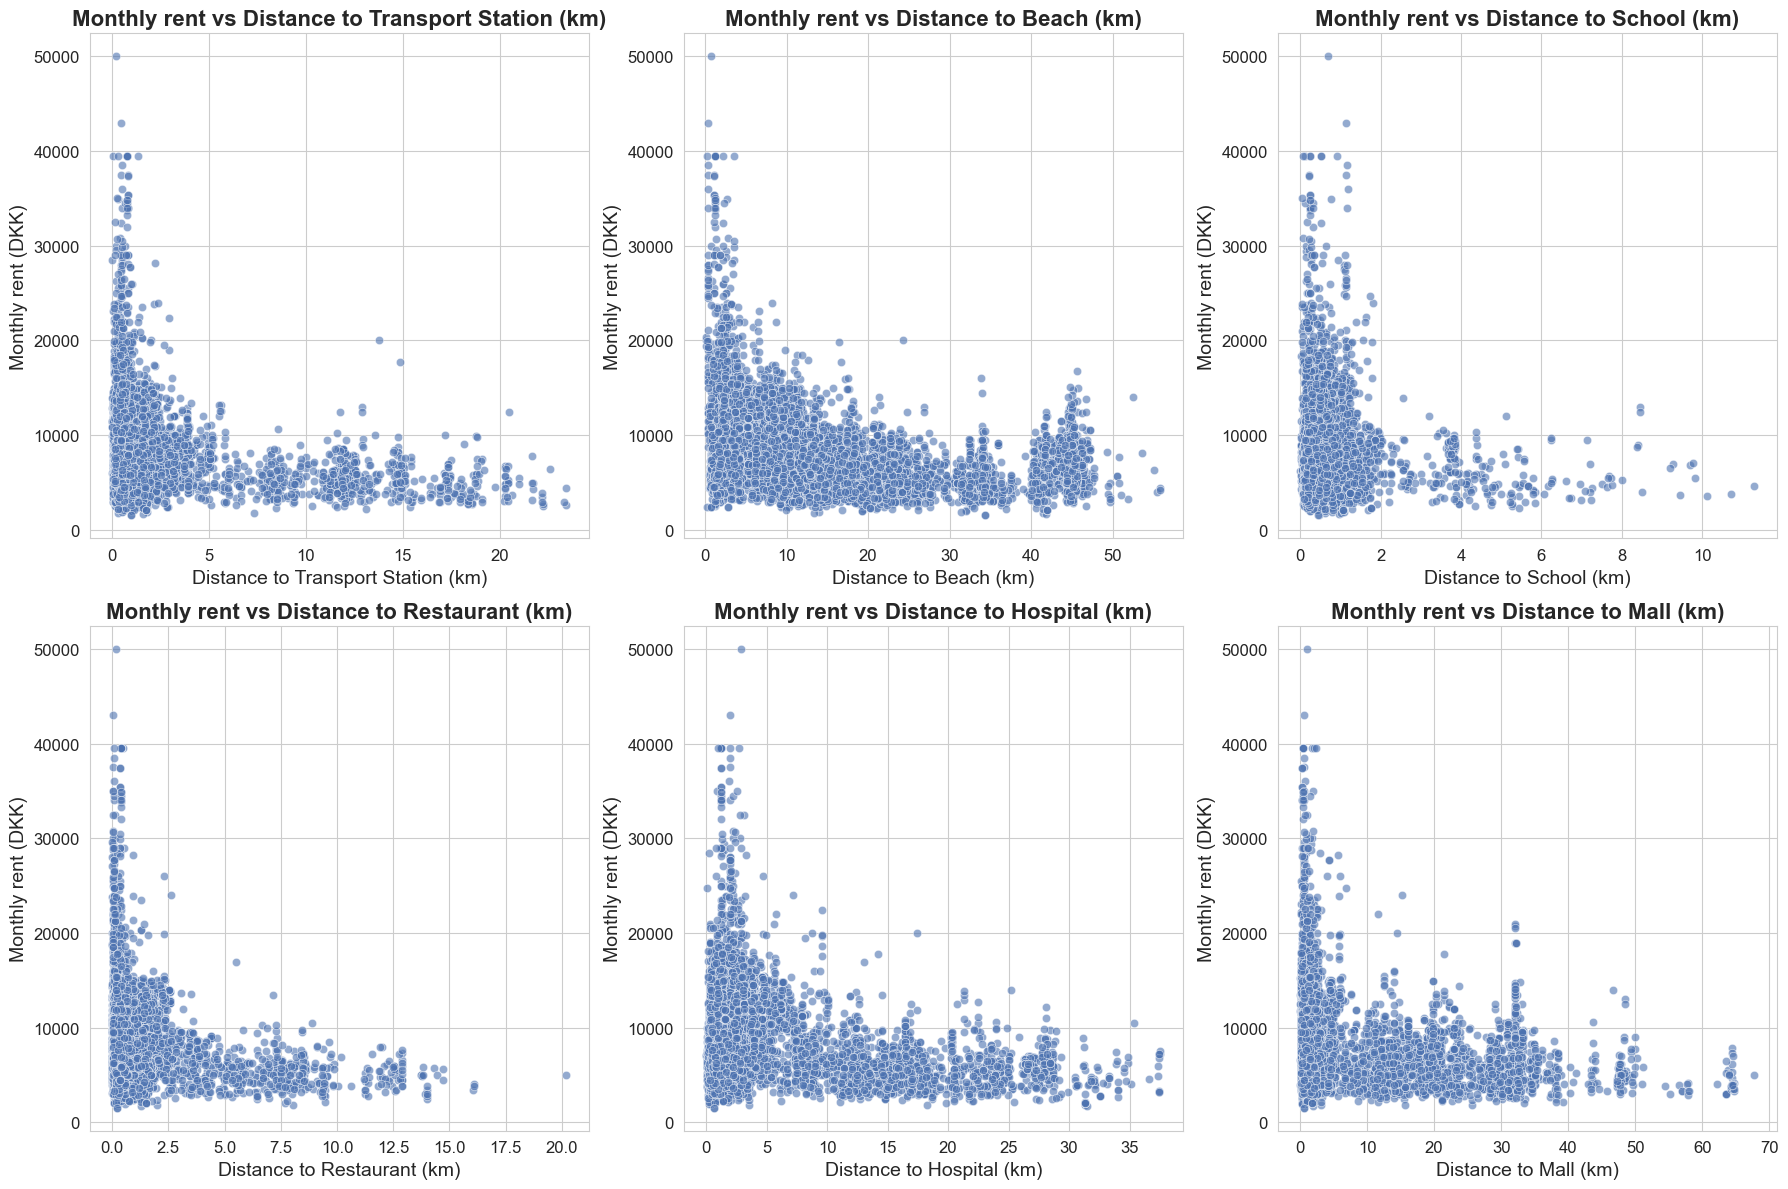

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sophisticated style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Load the dataset
final_data = pd.read_csv('4_Final_Data.csv')

# Define the target
target = "Monthly rent"

# Filter columns that start with "Distance to..."
distance_features = [col for col in final_data.columns if col.startswith("Distance to")]

# Create scatter plots grouped in 2 rows with 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, feature in enumerate(distance_features):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(final_data[feature], final_data[target], alpha=0.6, edgecolor='w', linewidth=0.5)
    axes[row, col].set_title(f'{target} vs {feature}', fontsize=16, fontweight='bold')
    axes[row, col].set_xlabel(feature, fontsize=14)
    axes[row, col].set_ylabel("Monthly rent (DKK)", fontsize=14)  # Set y-axis title
    axes[row, col].tick_params(axis='both', which='major', labelsize=12)
    axes[row, col].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig("4_Scatter_Plots.png", dpi=300, bbox_inches='tight')
plt.show()


Creating Scatter Plots: 100%|██████████| 30/30 [00:03<00:00,  9.23it/s]


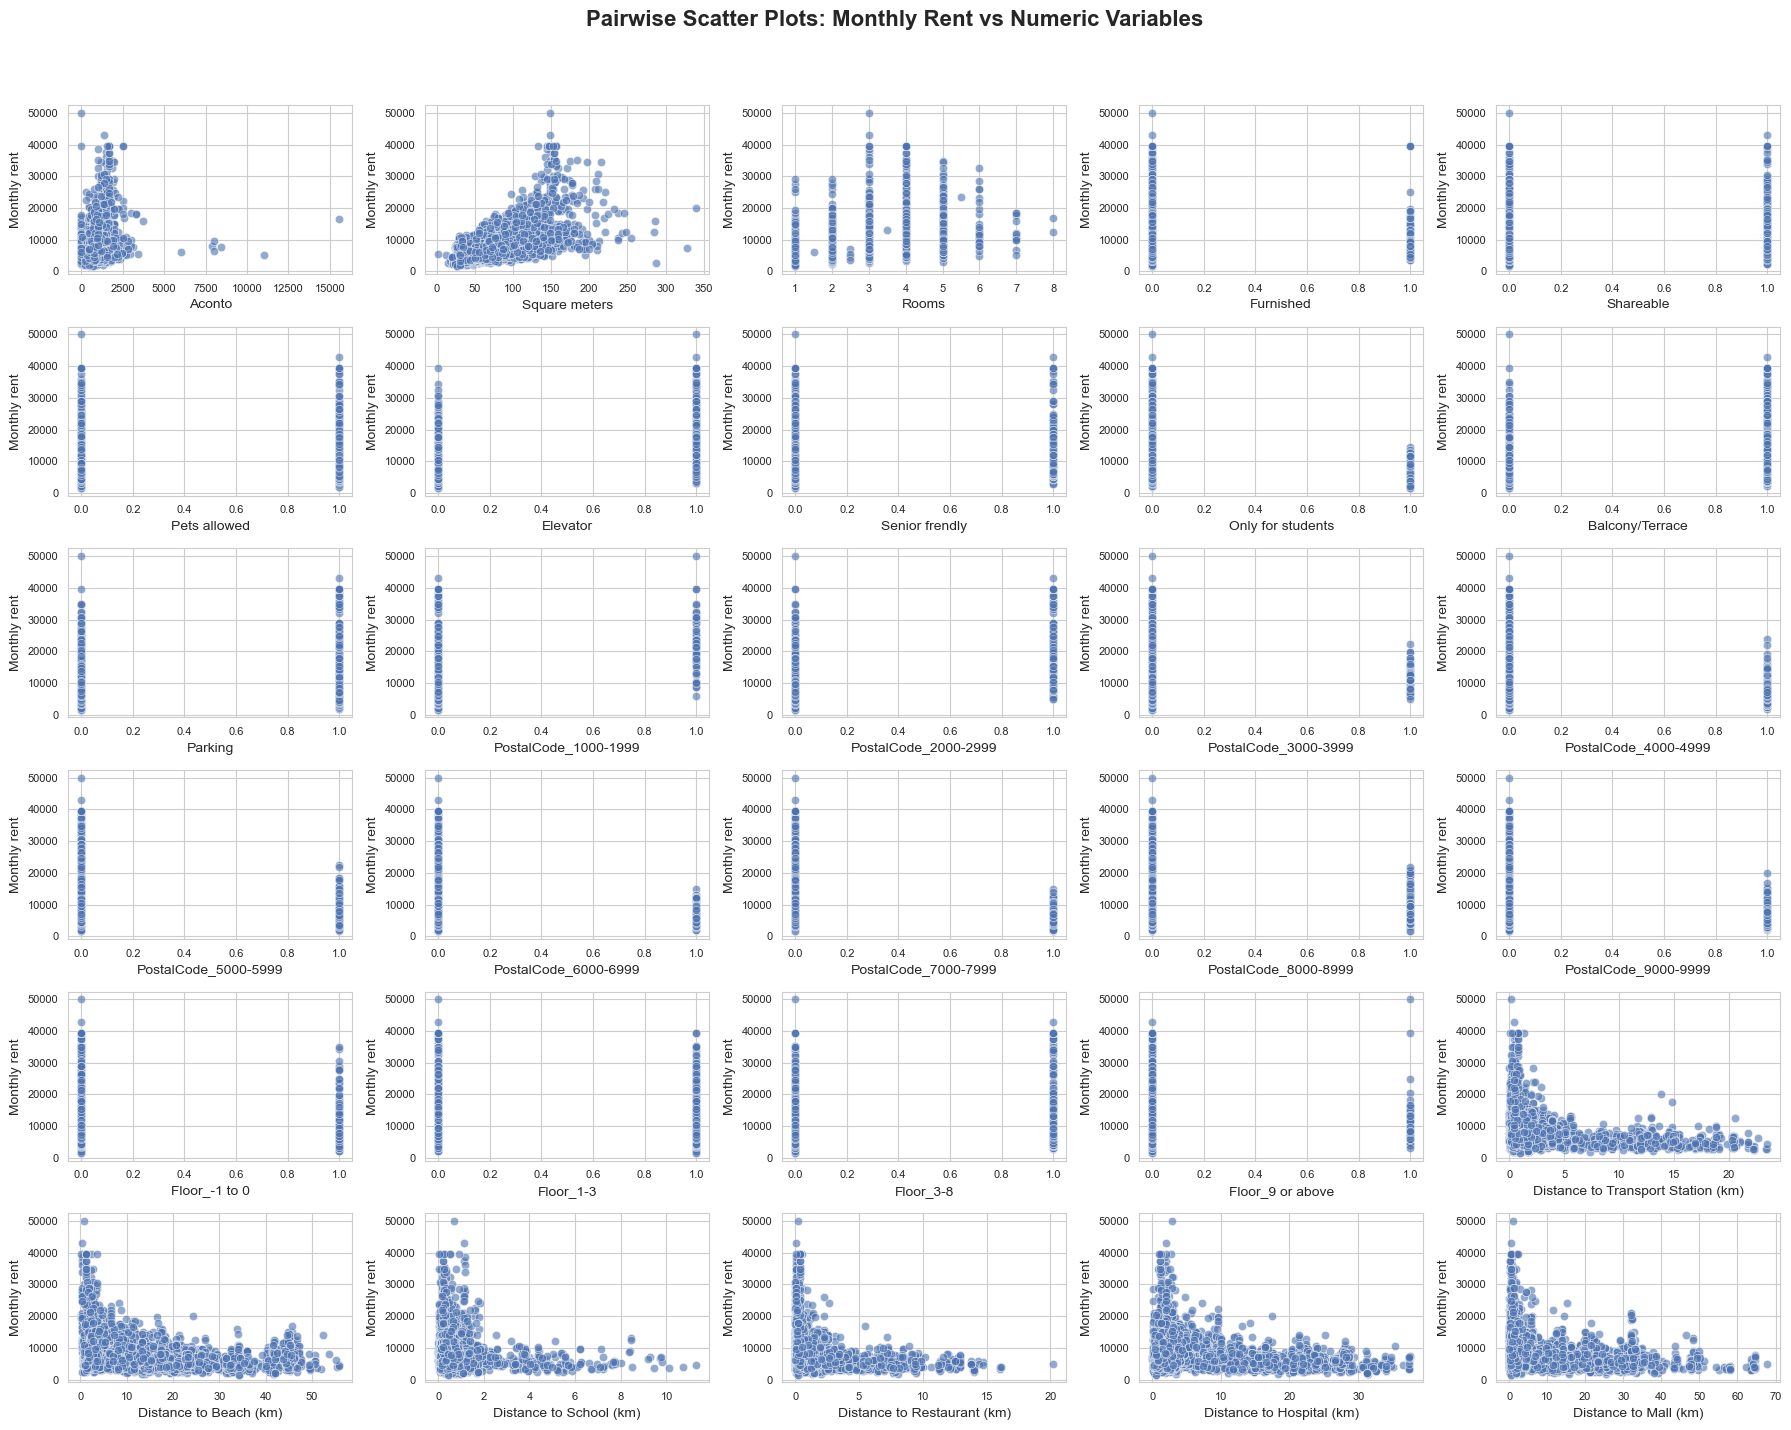

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set a sophisticated style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Load the dataset
final_data = pd.read_csv('4_Final_Data.csv')

# Exclude columns like 'Latitude' and 'Longitude'
columns_to_exclude = ['Latitude', 'Longitude', 'Monthly rent']
numeric_columns = final_data.select_dtypes(include=['number']).drop(columns=columns_to_exclude)

# Get the 'Monthly rent' column
monthly_rent = final_data['Monthly rent']

# Create a pairwise scatter plot grid between 'Monthly rent' and other numeric variables with a progress bar
num_columns = numeric_columns.shape[1]

# Set the number of rows and columns for subplots
num_rows = 6
num_cols = 5

# Calculate the total number of subplots
total_subplots = num_rows * num_cols

# Initialize tqdm with the total number of iterations
pbar = tqdm(total=total_subplots, desc="Creating Scatter Plots")

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))

for i, x_var in enumerate(numeric_columns.columns):
    row = i // num_cols
    col = i % num_cols
    
    sns.scatterplot(data=numeric_columns, x=x_var, y=monthly_rent, alpha=0.6, edgecolor='w', linewidth=0.5, ax=axes[row, col])
    axes[row, col].set_xlabel(x_var)
    axes[row, col].set_ylabel("Monthly rent")
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)
    
    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

# Add a title to the entire grid
fig.suptitle("Pairwise Scatter Plots: Monthly Rent vs Numeric Variables", fontsize=16, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("4_Pairwise_Scatter_Plot.png", dpi=300)
plt.show()
